# Implementation of Knowledge Based SDDC LCM.

### Import Library

In [47]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import re
import time
from time import strftime
from utils import util


### configure spark variables 

In [48]:
__author__ = 'raviranjan'

#from pyspark import SparkConf, SparkContext
#from pyspark.context import SparkContext
#from pyspark.sql.context import SQLContext
#from pyspark.sql.session import SparkSession
   
#sc = SparkContext()
#sqlContext = SQLContext(sc)
#spark = SparkSession(sc)

### Define variables contants

In [49]:
LOG_DIR = "logs"
TIME_STAMP_PATTERN = "^(2[0-3]|[01]?[0-9]):(0[1-9]{1}|[1-5]{1}[0-9]):(0[1-9]{1}|[1-5]{1}[0-9])$"
HOST_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
LOGGER_FILE_PATTERN = r'(^\S+\.[\S+\.]+\S+)\s'
ERROR_PATTERN = 'ERROR:'
INFO_PATTERN = 'INFO:'
DEBUG_PATTERN = 'DEBUG:'
time_stamp_pattern = r'\[(\d{2}/\w{3}/\d{4}:\d{2}:\d{2}:\d{2} -\d{4})]'
host_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
logger_file_pattern = r'(^\S+\.[\S+\.]+\S+)\s'
has_error_pattern = r''
excel_file_path = "data/excel_data.xlsx"



# Create a util class

In [50]:
import re
import os
import time
from time import strftime


def export_to_file(dict_with_list_values=None, export_file_path=None, export_folder=None):
    """
    dict_with_list_values = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [32000,35000,37000,45000]
        }
    :param export_folder:
    :param dict_with_list_values:
    :param create_dict_from_list:
    :param column_name
    :return:
    """
    if not export_file_path:
        time_now = str(strftime("%Y-%m-%d %H-%M-%S", time.localtime()))
        export_file_path = export_folder + "/" + time_now + ".xlsx"
    columns = dict_with_list_values.keys()
    print('Exporting columns %s to %s' % (columns, export_file_path))
    import pandas as pd
    df = pd.DataFrame(dict_with_list_values, columns=columns)
    df.to_excel(export_file_path, index=False, header=True)
    print(export_file_path)
    return export_file_path


def get_data_to_export(log_file, column_names=['line', 'info', 'error', 'debug', 'warn', 'exception']):
    excel_export_data = {
    }
    for column_name in column_names:
        excel_export_data[column_name] = []
    print("Define column %s" % excel_export_data)
    with open(log_file) as f:
        for line in f:
            one_row_values = {} # store one row value with key as column name and its value
            for column_name in column_names:
                column_name = column_name.lower()
                line = line.lower().strip()
                if column_name in line:
                    column_value = 1
                else:
                    column_value = 0
                if column_name == "line":
                    one_row_values[column_name] = line
                else:
                    one_row_values[column_name] = column_value
            for column_name in one_row_values:
                # append the list value
                existing_one_column_values = excel_export_data[column_name]
                existing_one_column_values.append(one_row_values[column_name])
                excel_export_data[column_name] = existing_one_column_values

    # print("%s" % excel_export_data)
    return excel_export_data


def get_log_files(log_dir):
    log_files = []
    for root, dir_, files in os.walk(log_dir):
        for sub_dir in dir_:
            sub_dir_path = os.path.join(root, sub_dir)
            print("sub_dir: %s" % sub_dir_path)
            # os.system('ls %s' % sub_dir_path)
        for f in files:
            f_path = os.path.join(root, f)
            if ".log" in f_path:
                log_files.append(f_path)
    print("Log file under %s are %s" % (log_dir, log_files))
    return log_files


def findall_(log_file, regex):
    matched_lines = []
    with open(log_file) as f:
        # lines = f.readlines()
        for line in f:
            found = re.findall(regex, line)
            if found:
                matched_lines.append(line)
        print(matched_lines)
    return matched_lines


def search_re(line, pattern=None):
    # Python program to illustrate
    # Matching regex objects
    match = re.match(pattern, line)
    if not match:
        regex_com = re.compile(pattern)
        match = regex_com.search(line)
        if match:
            value = match.group()
            print('found using re.compile: %s' % value)
            return value
        else:
            print('%s not Found using re.compile also:' % pattern)
            return ''
    else:
        value = match.group()
        print('Found using re.match: %s' % value)
        return value


def finditer_(log_file_path, regex, read_line=True, re_parse=False):
    """
    regex = '(<property name="(.*?)">(.*?)<\/property>)'
    :param log_file_path:
    :param regex:
    :param read_line:
    :param re_parse:
    :return:
    """
    with open(log_file_path, "r") as f:
        match_list = []
        if read_line:
            for line in f:
                for match in re.finditer(regex, line, re.S):
                    match_text = match.group()
                    print(match_text)
                    print(line)
                    match_list.append(match_text)
        else:
            data = f.read()
            for match in re.finditer(regex, data, re.S):
                match_text = match.group()
                match_list.append(match_text)
    f.close()
    if re_parse:
        match_list = finditer_again(match_list, regex)
    print(match_list)
    return match_list


def finditer_again(parsed_data, regex):
    data_string = ''.join(parsed_data)
    match_list = []
    for match in re.finditer(regex, data_string, re.S):
        match_text = match.group()
        match_list.append(match_text)
    print(match_list)
    return match_list


### Get log files

In [51]:
log_files = get_log_files(log_dir=LOG_DIR)
# print(log_files)

sub_dir: logs/0b9eb3a5-950f-4c44-b81a-42988431a125
Log file under logs are ['logs/client_proxy.log', 'logs/0b9eb3a5-950f-4c44-b81a-42988431a125/test-rst.log']


### Get Data from logs and export to Excel 

In [52]:
#excel_export_data = get_data_to_export(log_file=log_files[0], column_names=['line', 'info', 'error', 'debug', 'warn', 'exception'])

#export_to_file(dict_with_list_values=excel_export_data, export_file_path=excel_file_path)

# Analyzing Data

In [53]:
excel_data = pd.read_excel(excel_file_path)
excel_data.head(5)

,line,info,error,debug,warn,exception
0,04/22/2021 06:05:46 am: debug:\tclient_proxy:4...,0,0,1,0,0
1,04/22/2021 06:05:47 am: debug:\tclient_proxy:4...,0,0,1,0,0
2,04/22/2021 06:05:52 am: debug:\tclient_proxy:4...,0,0,1,0,0
3,04/22/2021 06:05:52 am: debug:\tclient_proxy:4...,0,0,1,0,0
4,04/22/2021 06:05:57 am: debug:\tclient_proxy:4...,0,0,1,0,0


### Draw few plot


In [54]:
print((excel_data.info()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82520 entries, 0 to 82519
Data columns (total 6 columns):
line         82509 non-null object
info         82520 non-null int64
error        82520 non-null int64
debug        82520 non-null int64
warn         82520 non-null int64
exception    82520 non-null int64
dtypes: int64(5), object(1)
memory usage: 3.8+ MB
None


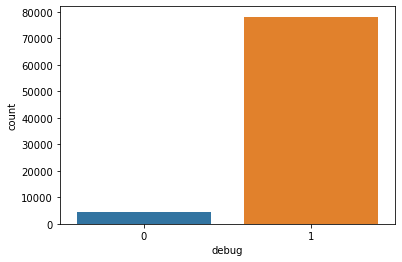

In [55]:
# how many rows having debug value
sns.countplot(x="debug", data=excel_data)

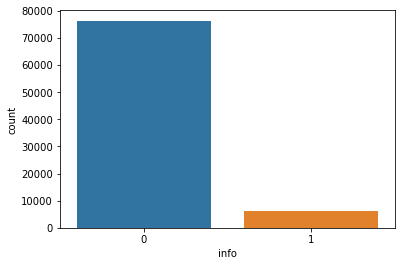

In [56]:
# how many rows having info value
sns.countplot(x="info", data=excel_data)

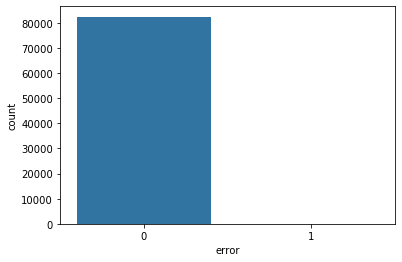

In [57]:
# how many rows having error value
sns.countplot(x="error", data=excel_data)

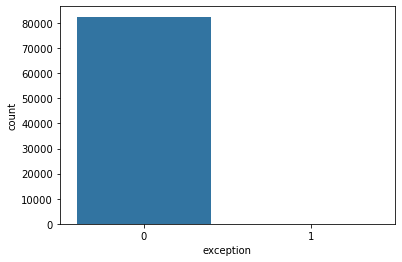

In [58]:
# how many rows having exception value
sns.countplot(x="exception", data=excel_data)

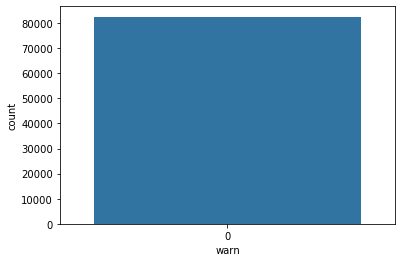

In [59]:
# how many rows having warn value
sns.countplot(x="warn", data=excel_data)

### Draw histogram 

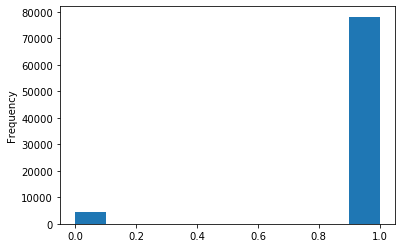

In [60]:
excel_data['debug'].plot.hist()


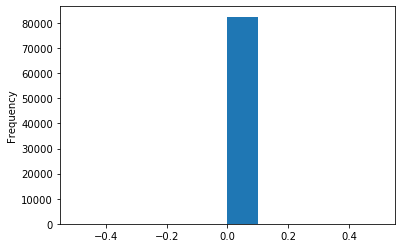

In [61]:
excel_data['warn'].plot.hist()

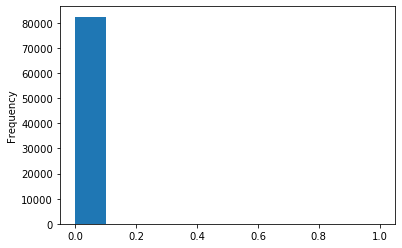

In [62]:
excel_data['error'].plot.hist()

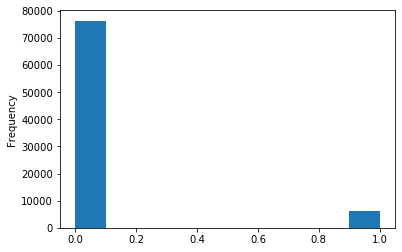

In [63]:
excel_data['info'].plot.hist()

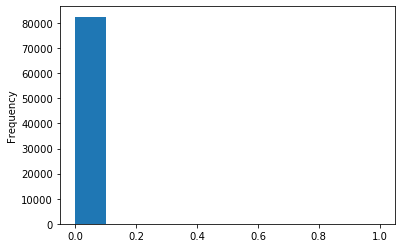

In [64]:
excel_data['exception'].plot.hist()

#  Data Wrangling


In [65]:
# Data Wrangling is to remove null or empty data, cleaning data set

In [66]:
print((excel_data.info()))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82520 entries, 0 to 82519
Data columns (total 6 columns):
line         82509 non-null object
info         82520 non-null int64
error        82520 non-null int64
debug        82520 non-null int64
warn         82520 non-null int64
exception    82520 non-null int64
dtypes: int64(5), object(1)
memory usage: 3.8+ MB
None


In [67]:
excel_data.isnull()


,line,info,error,debug,warn,exception
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
...,...,...,...,...,...,...
82515,False,False,False,False,False,False
82516,False,False,False,False,False,False
82517,False,False,False,False,False,False
82518,False,False,False,False,False,False


In [68]:
excel_data.isnull().sum()


line         11
info          0
error         0
debug         0
warn          0
exception     0
dtype: int64

In [69]:
sns.heatmap(excel_data.isnull(), yticklabels==False)


NameError: name 'yticklabels' is not defined

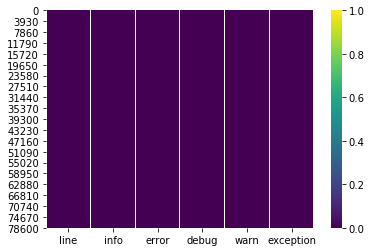

In [70]:
sns.heatmap(excel_data.isnull(), cmap="viridis")


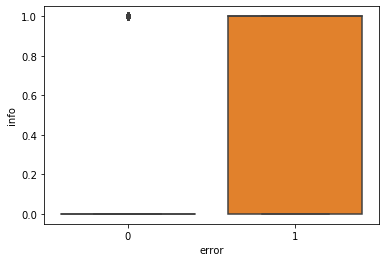

In [71]:
sns.boxplot(x="error", y="info", data=excel_data)


In [72]:
# either drop that row or fill some value where value is null
excel_data.head(5)
excel_data.isnull().sum()


line         11
info          0
error         0
debug         0
warn          0
exception     0
dtype: int64

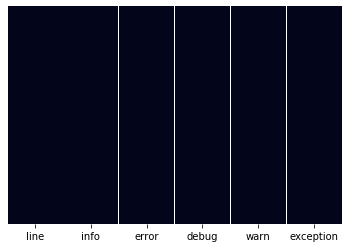

In [73]:
sns.heatmap(excel_data.isnull(), yticklabels=False, cbar=False)


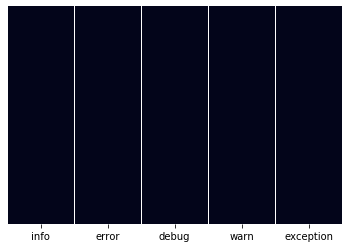

In [74]:
excel_data.drop("line", axis=1, inplace=True)
sns.heatmap(excel_data.isnull(), yticklabels=False, cbar=False)


In [75]:
excel_data.isnull().sum()


info         0
error        0
debug        0
warn         0
exception    0
dtype: int64

### hold column values in variable


In [80]:
info=pd.get_dummies(excel_data['info'])

In [81]:
excel_data = pd.concat([excel_data, info], axis=1)
excel_data.head(5)


,info,error,debug,warn,exception,0,1
0,0,0,1,0,0,1,0
1,0,0,1,0,0,1,0
2,0,0,1,0,0,1,0
3,0,0,1,0,0,1,0
4,0,0,1,0,0,1,0


In [98]:
excel_data.drop(['info'], axis=True, inplace=True)
excel_data.head(5)

,error,debug,warn,exception,0,1
0,0,1,0,0,1,0
1,0,1,0,0,1,0
2,0,1,0,0,1,0
3,0,1,0,0,1,0
4,0,1,0,0,1,0


#  Train and Test

In [84]:
X = excel_data.drop("error", axis=1)
y = excel_data["error"]

In [85]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [88]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()

In [89]:
logmodel.fit(X_train, y_train)


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [91]:
predictions = logmodel.predict(X_test)

In [95]:
from sklearn.metrics import classification_report
classification_report(y_test, predictions)


'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00     27210\n           1       0.00      0.00      0.00        22\n\n    accuracy                           1.00     27232\n   macro avg       0.50      0.50      0.50     27232\nweighted avg       1.00      1.00      1.00     27232\n'

In [96]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)


array([[27210,     0],
       [   22,     0]])

In [97]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, predictions)


0.9991921269095182

#  Collecting Data


# Accuracy Check
